# Using Python and Monte Carlo to Simulate Student Finance Amortization

## TL;DR - Quick Abstract
I became frustrated with the numbers not adding up on my Student Loan statements and speculative opinions about never paying it off and getting the loan cancelled. I wanted to gauge my likelihood of paying off the full loan and simulated my earnings using Monte Carlo and another method. I used Python to implement it - code walk through below.

## Intro

In the last year, I have developed a keen interest in personal finance and utilising automation to improve the handling and growth of personal finances (triggered by Ramit Sethi's amazing [book](https://www.amazon.co.uk/Will-Teach-You-Rich-Second/dp/1523505745/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=&sr=) and [blog](https://www.iwillteachyoutoberich.com/), which I highly recommend). I became interested in my Student Loan and my lifetime repayment (amortization) of it. 

In the UK, students can take out university loans for both tuition fees and living costs ("maintenance loans") with [Student Finance England](https://www.gov.uk/student-finance), who provide loans underwritten by the Student Loans Company who act on behalf of the government. Once you leave university and enter employment you then begin to pay off your loan on a monthly schedule, as part of your tax deductions. Crucially, if you do not pay off your loan, plus interest, in 30 years, your loan is cancelled.

## Rationale

There are several reasons I became so interested in and, frankly, frustratingly intrigued by this project:
* The **main reason**: the more reading I did into the loans, the more I realised how murky and dense a lot of the documentation is surrounding repayment - even analysing my statements from the Student Loans Company for the interest accrued in a given period didn't make sense when I ran the numbers - it seems purposefully confusing, and no-one online or in my circle could give me clear answers
* Conflicting opinions surrounding paying off the loan - everything from "it comes out of my tax so I don't even notice it", to "most students won't pay it off and it will get cancelled, so paying upfront might be wasting your money"
* Graduates today in the UK, leave university with a staggering sum of debt - I wanted to cut through the noise and undertand exactly what goes on underneath

Now, working in Data Science, and trained at university as a scientist, nothing annoys me more than the concept of not needing to understand something, or learning something superficially. I left university with a total of £42,000 in debt, and so the notion of blindly paying a huge debt and not knowing how it works really frustrated me. 

## Questions
Here are the questions I wanted to answer:
1. How likely am I, and other graduates, to pay off our student loans inside of the 30 year payment window, following university courses?
2. If you manage to save money, or come across a sum of money (e.g. inheritance), should you put it towards your loan in the form of voluntary payments?

## Facts
* Students taking out loans since 2012 are on "Plan 2" loans
* You only start paying these back when you earn more than £2,214 a month or £26,568 a year (pre-tax)
* You are due to start repaying the April after graduating (or the April 4 years after starting - whichever comes first)
* You begin acruing interest from the day of your first loan (i.e. shortly after arriving at university)
* Interest acrues daily
* Plan 2 loans are written off 30 years after the April you were first due to repay

## Student Loans are not like other loans
* Regular loans from the bank are drawn up with a fixed interest rate and regular payments (e.g. monthly)
* The amount you pay back to your Student Loan is determined by how much you earn, so it behaves much more like a tax
* In this way, people who earn more contribute more, paying for the loans of graduates who earn less
* Interest rates are variable, not fixed - they are calculated as inflation plus 3%, so rates have been as high as x% in recent years

# Import Python Libraries

In [23]:
import os
import pandas as pd
import numpy as np

# Working with datetime objects
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd

# Scraping interest rates off the web
import requests
from bs4 import BeautifulSoup

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Build Functions
Read in my student finance statements for all loan instalments and interest payments throughout my degree

In [24]:
def readPayments(file_name, date_header="PaymentDate"):
    '''Reads in student finance statement'''
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc, index_col=date_header, parse_dates=True)
#     paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

In [25]:
# Read in my statement detailing university instalments
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)
myPayments.head()

,Instalment,Gross
PaymentDate,,
2014-09-25,1,1191.3
2014-10-15,1,2250.0
2015-01-05,2,1191.3
2015-02-04,2,2250.0
2015-04-20,3,1227.4


Some basic functions for calculating tax (based on UK [tax bands](https://www.gov.uk/income-tax-rates)), [national insurance contribution (NIC)](https://www.gov.uk/national-insurance/how-much-you-pay) and [student finance payments](https://www.gov.uk/repaying-your-student-loan/what-you-pay) based on your gross salary (pre-tax).

In [26]:
def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA

At certain points in my simulation, my salary increases by a random amount drawn from a gaussian distriubtion - the parameters of which are iterated over. This simulates career progression - changing to a job with a higher salary or receiving a payrise.

In [27]:
def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian distribution'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

To calculate how much I owed at the end of university, I need to calculate the interest that is applied to a given instalment, which changes at the start each academic year (September 1st). The first part was to get these rates from the [government website](https://www.gov.uk/guidance/how-interest-is-calculated-plan-2), using a simple web scraper (```BeautifulSoup```) which takes the interest rates for different academic years from the government website and stores them in a dictionary. The second part was to build a function which could take any date during my degree and find the interest rate at that point in time.

In [28]:
## Web scrape historic interest rates

url = 'https://www.gov.uk/guidance/how-interest-is-calculated-plan-2'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')
table_rows = results.find_all('tr')

# Store interest rates in dictionary of academic years
historicInterest = {}
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) > 0:
        row[0] = row[0].split('to')
        row[0][0] = pd.Timestamp(row[0][0])
        row[0][1] = pd.Timestamp(row[0][1])
        year = str(row[0][0].year)
        historicInterest.setdefault(year, 0)
        historicInterest[year] = {}
        historicInterest[year].setdefault("start", 0)
        historicInterest[year]["start"] = row[0][0].date()
        historicInterest[year].setdefault("end", 0)
        historicInterest[year]["end"] = row[0][1].date()
        historicInterest[year].setdefault("rate", 0)
        historicInterest[year]["rate"] = float(row[1][:-1])/100

def findInterestRate(paymentDate):
    '''Finds interest rate of loan for a given date'''
    try:
        year = paymentDate.year
        sdate = historicInterest[str(year)]["start"]
        edate = historicInterest[str(year)]["end"]
        delta = edate - sdate
    
        allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)] # create list of all dates in date range sdate to edate

        if paymentDate in allDates:
            rate = historicInterest[str(year)]["rate"]
        else:
            rate = historicInterest[str(year-1)]["rate"]
    except KeyError: # key error will occur for dates in years that have no published interest rate as they don't appear in dictionary
        rate = historicInterest[str(year-1)]["rate"]
    return rate

To calculate how much I owed after university I need to simulate each passing day's interest (whilst studying) and also add in the instalments arriving from Student Finance England. You can either simulate up to the end of graduation year (August 31st), or up to the start of employment (when you begin paying back the loan), using the ```simEnd``` argument.

In [29]:
def graduateAmount(simEnd, employmentStart, myPayments=None): # simEnd argument ends simulation either on the last payment in data, at the end of graduation academic year or at commencement of employment
    '''calculate total student debt owed in graduation year or manually input total'''
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = myPayments.index.min()
        if simEnd == "yearEnd":
            graduationYear = myPayments.index.max().year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = myPayments.index.max() # simulation ends at final payment

        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            interestRate = findInterestRate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in myPayments.index:
                cumulativeTotal += myPayments.loc[startDate]["Gross"]
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

In [30]:
def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = findInterestRate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

### The Main Function!
Using the above functions, the value owed in Student Finance at the start of employment can be calculated. From this point onwards, you begin paying back towards your loan in the style of a tax. In this simulation, interest accrues on the loan daily, and on the last working day of the month (```BMonthEnd()```), your repayment comes out of your salary (details in intro), as in reality. 

In [31]:
def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start, frequency, mean_salary_increase, mean_salary_sd):
    '''Simulates payment of student debt across career based on monthly tax payments according to
    estimate salary and compounding interest of loan'''
    salary = []
    salary.append(grossSalaryPA)
    
    today = pd.Timestamp(employment_start)
    start = today
    edate = today + timedelta(days=N*365)
    delta = timedelta(days=1)
    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while today <= edate:
#         if ((today - start).days/365)%frequency == 0 and ((today - start).days/365) > 0:
#             grossSalaryPA = salaryIncrease(grossSalaryPA, mean=mean_salary_increase, sd=mean_salary_sd)
        if (today - start).days%365 == 0 and (today - start).days/365 in male_HE.index:
            grossSalaryPA = male_HE.loc[(today - start).days/365]['Earning']
#             grossSalaryPA += np.random.normal(0.1*grossSalaryPA,0.2*0.1*grossSalaryPA)
#             if grossSalaryPA > 150000:
#                 grossSalaryPA = 150000
            
        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if today == offset.rollforward(today) and today.month == offset.rollforward(today).month: # if today in sim is last working day
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            salary.append(grossSalaryPA)
            
        today += delta

    return cumulativeList, salary

## Simulating Median Graduate Earnings
Using data from an incredibly thorough new report [*The impact of undergraduate degree on lifetime earnings*](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/869263/The_impact_of_undergraduate_degrees_on_lifetime_earnings_research_report_ifs_dfe.pdf), I can run the simulation for median male and female graduate earnings.

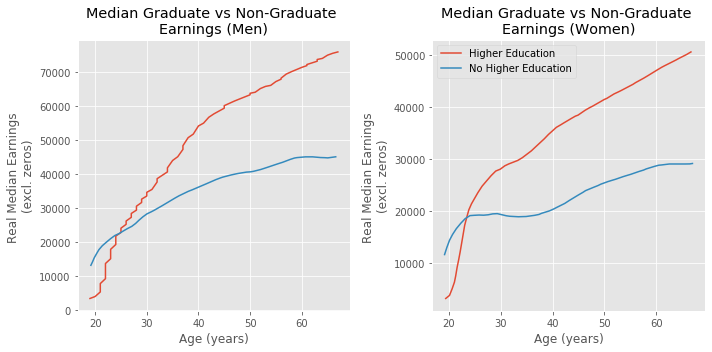

In [33]:
male_HE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_men_HE.csv"),header=None, names = ['Age', 'Earning'])
male_noHE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_men_nonHE.csv"), header=None, names = ['Age','Earning'])
female_HE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_women_HE.csv"),header=None, names = ['Age', 'Earning'])
female_noHE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_women_nonHE.csv"), header=None, names = ['Age','Earning'])

male_HE['Age'] = male_HE['Age'].round()


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
axes[0].plot(male_HE['Age'], male_HE['Earning'], label = "Higher Education")
axes[0].plot(male_noHE['Age'], male_noHE['Earning'], label = "No Higher Education")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Real Median Earnings \n(excl. zeros)")
axes[0].title.set_text('Median Graduate vs Non-Graduate \nEarnings (Men)')
axes[1].plot(female_HE['Age'], female_HE['Earning'], label = "Higher Education")
axes[1].plot(female_noHE['Age'], female_noHE['Earning'], label = "No Higher Education")
axes[1].set_xlabel("Age (years)")
axes[1].set_ylabel("Real Median Earnings \n(excl. zeros)")
axes[1].title.set_text('Median Graduate vs Non-Graduate \nEarnings (Women)')
plt.legend(loc="best")
plt.tight_layout()

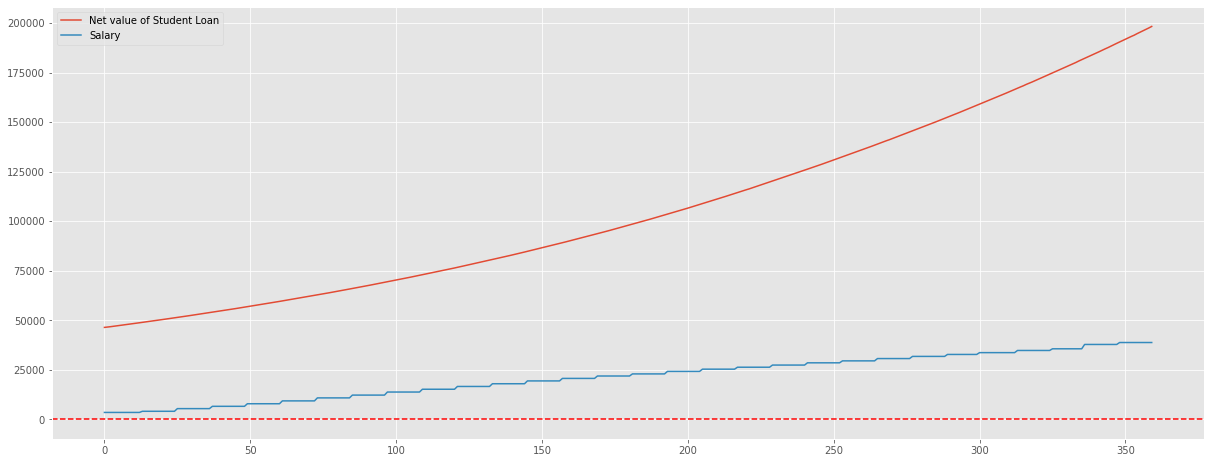

In [41]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
salary_increases = np.arange(3000,11000,500)    
salary_increases_frequency = np.arange(3,9,1)
trajectories = np.zeros((len(salary_increases),len(salary_increases_frequency)))
for i in range(1):
    sim, sal = simulateLifetimeEarnings(grossSalaryPA = male_HE['Earning'].min(), 
                            N = 30, 
                            principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                            employment_start = "2019-10-07", 
                            frequency = 1, 
                            mean_salary_increase = 1, 
                            mean_salary_sd = 2500)
#     trajectories[i,j] = sim[-1]

    ax.plot(sim, label = "Net value of Student Loan")
    ax.plot(sal, label = "Salary")
plt.legend(loc="best");


As you can see in the plot above, the median male graduate's salary dooes not increase fast enough over the 30 years to ever overcome the rate of compounding of the loan interest. Thus, the loan's net value spirals upwards, and they never pay it off. At 30 years, the loan will be cancelled. However, there are many confounding variables here - e.g. this is averaged across subjects and university (e.g. [Russell Group](https://russellgroup.ac.uk/about/) and nonRG), which have large variance. So this should be looked at purely as an example.

# Enter Monte Carlo
As suggested by the name, Monte Carlo simulations

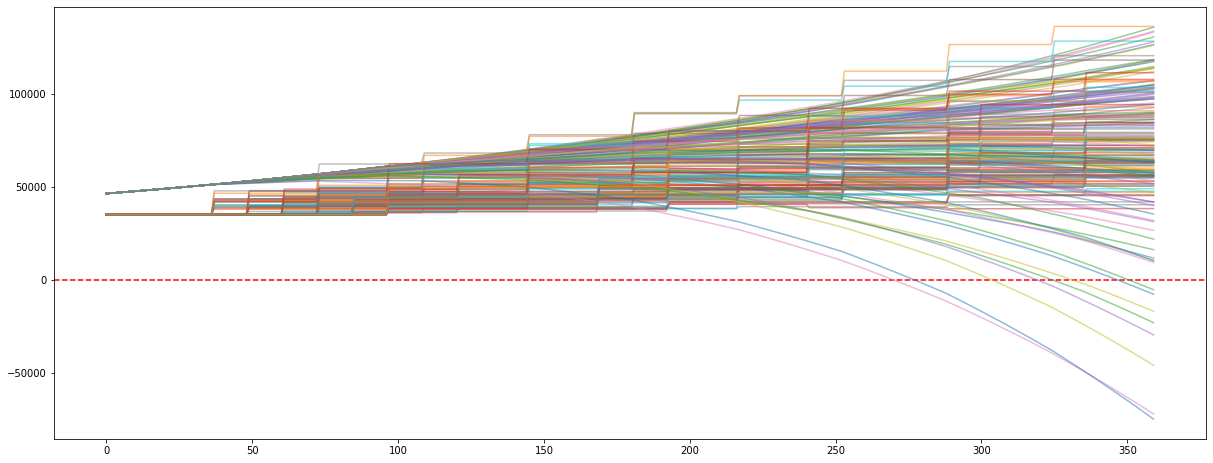

In [10]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
salary_increases = np.arange(3000,11000,500)    
salary_increases_frequency = np.arange(3,9,1)
trajectories = np.zeros((len(salary_increases),len(salary_increases_frequency)))
for i in range(len(salary_increases)):
    for j in range(len(salary_increases_frequency)):
        sim, sal = simulateLifetimeEarnings(grossSalaryPA = 35000, 
                                N = 30, 
                                principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                employment_start = "2019-10-07", 
                                frequency = salary_increases_frequency[j], 
                                mean_salary_increase = salary_increases[i], 
                                mean_salary_sd = 2500)
        trajectories[i,j] = sim[-1]
        
        ax.plot(sim, alpha = 0.5)
        ax.plot(sal, alpha = 0.5)
        

In [17]:
salary_increases_frequency[-1]

8

In [11]:
yaynay = trajectories <= 0
yaynay

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True,  True, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True,  True, False, False, False, False]])

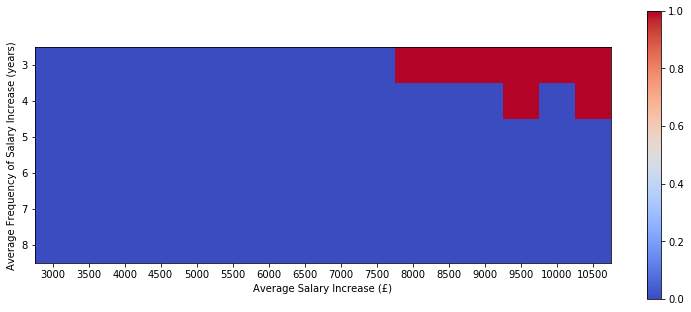

In [12]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

# We want to show all ticks...
ax.set_xticks(np.arange(len(salary_increases)))
ax.set_xlabel('Average Salary Increase (£)')
ax.set_yticks(np.arange(len(salary_increases_frequency)))
ax.set_ylabel('Average Frequency of Salary Increase (years)')
# ... and label them with the respective list entries
ax.set_xticklabels(salary_increases)
ax.set_yticklabels(salary_increases_frequency)

heatmap = ax.imshow(yaynay.astype(int).transpose(), cmap='coolwarm', interpolation='nearest')
# ax.imshow()
fig.colorbar(heatmap)